In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import math

In [2]:
K = np.loadtxt('K.txt')

In [3]:
K

array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03],
       [0.0000000e+00, 3.1174740e+03, 9.8476840e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

In [4]:
img0 = cv2.imread('sequence/000001.png')
im0 = cv2.cvtColor(img0,cv2.COLOR_BGR2GRAY)
img1 = cv2.imread('sequence/000002.png')
im1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('sequence/000003.png')
im2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

# Exercise 11.1

In [5]:
sift = cv2.SIFT_create()
kp0, des0 = sift.detectAndCompute(im0, None)##key points and description
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

In [6]:
kp0 = np.array([k.pt for k in kp0]).astype('float32')
kp1 = np.array([k.pt for k in kp1]).astype('float32')
kp2 = np.array([k.pt for k in kp2]).astype('float32')

In [7]:
bf = cv2.BFMatcher(crossCheck=True)
matches01 = bf.match(des0, des1)
matches12 = bf.match(des1, des2)

In [8]:
matches01 = np.array([(m.queryIdx, m.trainIdx) for m in matches01])
matches12 = np.array([(m.queryIdx, m.trainIdx) for m in matches12])

In [9]:
kp0_matched = kp0[matches01[:,0]]
kp1_matched = kp1[matches01[:,1]]

In [10]:
kp1_matched

array([[2372.441   , 1931.2302  ],
       [ 117.9529  ,  901.91724 ],
       [ 389.25607 ,  671.17993 ],
       ...,
       [  10.262258, 1716.8942  ],
       [ 249.35669 ,  573.08466 ],
       [ 404.9805  ,  715.65564 ]], dtype=float32)

# Exercise 11.2

In [11]:
E1,_ = cv2.findEssentialMat(kp1_matched,kp0_matched,  focal=K[0,0],pp=(K[0,2],K[1,2]))
E1

array([[ 0.00213344, -0.27078293,  0.0530629 ],
       [ 0.26572567,  0.03341392,  0.65318944],
       [-0.03405237, -0.65068707,  0.03033292]])

In [12]:
retval, R1, t1, mask = cv2.recoverPose(E1, kp0_matched, kp1_matched)

In [13]:
R0 = np.eye(3, 3)
t0 = np.zeros((3, 1))
Rs = [R0,R1]
ts = [t0,t1]

In [14]:
R1

array([[ 0.99989346,  0.0099676 ,  0.0106636 ],
       [-0.00945317,  0.99883837, -0.04724994],
       [-0.01112218,  0.0471441 ,  0.99882618]])

In [15]:
t1

array([[ 0.92071318],
       [-0.05686703],
       [-0.38607431]])

In [16]:
inliers = mask.ravel().view('bool')
matches01_inliers = matches01[inliers,:]

In [17]:
matches01_inliers = matches01[inliers,:]

# Exercise 11.3

In [18]:
_, idx01, idx12 = np.intersect1d(matches01_inliers[:,1], matches12[:,0], return_indices=True)

In [19]:
points0 = kp0[matches01_inliers[idx01,0]].astype(np.float32)
points1 = kp1[matches01_inliers[idx01,1]].astype(np.float32)
points2 = kp2[matches12[idx12,1]].astype(np.float32)

# Exercise 11.4

In [20]:
P0 = K@np.hstack((R0,t0))
P1 = K@np.hstack((R1,t1))
Ps = [P0,P1]

In [21]:
Q = cv2.triangulatePoints(P0, P1, points0.T, points1.T)

In [22]:
Qih = (Q[:-1]/Q[-1]).T.astype(np.float64)

In [23]:
Qih.shape

(4685, 3)

In [24]:
Qih

array([[ 1.72331848e+01, -1.01366510e+01, -3.58216515e+01],
       [-2.47340858e-01,  1.43968163e-03, -9.53012764e-01],
       [-3.22039902e-01, -1.29117534e-01, -8.30406845e-01],
       ...,
       [ 8.93276882e+00,  3.93112993e+00,  2.13830700e+01],
       [-1.32824823e-01,  3.08050662e-01,  2.05160451e+00],
       [ 6.97215843e+00,  2.55183578e+00,  1.72368221e+01]])

In [25]:
_, rvecs, tvecs, inliers = cv2.solvePnPRansac(Qih, points2, K, distCoeffs=np.zeros(5))

In [26]:
Orientation0 = R0.T
Poistion0 = -R0.T@t0
Orientation1 = R1.T
Poistion1 = -R1.T@t1
Os = [Orientation0,Orientation1]
Pos = [Poistion0,Poistion1]

In [28]:
R2, _ = cv2.Rodrigues(rvecs)
Orientation2 = R2.T
Poistion2 = - R2.T @ tvecs
Rs.append(R2)
ts.append(tvecs)
Ps.append(K@np.hstack((R2,tvecs)))
Os.append(Orientation2)
Pos.append(Poistion2)
print('Position:{}'.format(Poistion2))
print('Orientation:{}'.format(Orientation2))

Position:[[-2.00123178]
 [ 0.12494489]
 [ 1.70228615]]
Orientation:[[ 0.99934676 -0.00208979 -0.03607888]
 [ 0.00126071  0.99973497 -0.02298709]
 [ 0.03611736  0.02292659  0.99908453]]


In [29]:
Os

[array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[ 0.99989346, -0.00945317, -0.01112218],
        [ 0.0099676 ,  0.99883837,  0.0471441 ],
        [ 0.0106636 , -0.04724994,  0.99882618]]),
 array([[ 0.99934676, -0.00208979, -0.03607888],
        [ 0.00126071,  0.99973497, -0.02298709],
        [ 0.03611736,  0.02292659,  0.99908453]])]

In [30]:
rvecs

array([[-0.02296385],
       [ 0.03610916],
       [-0.00167576]])

In [31]:
tvecs

array([[ 1.9382849 ],
       [-0.16812154],
       [-1.77005785]])

In [32]:
Qinliers = Qih[inliers.flatten()]
Qs = [Qinliers]

In [33]:
Qinliers.shape

(1504, 3)

In [37]:
Pos

[array([[0.],
        [0.],
        [0.]]),
 array([[-0.92544665],
        [ 0.0658248 ],
        [ 0.37311605]]),
 array([[-2.00123178],
        [ 0.12494489],
        [ 1.70228615]])]

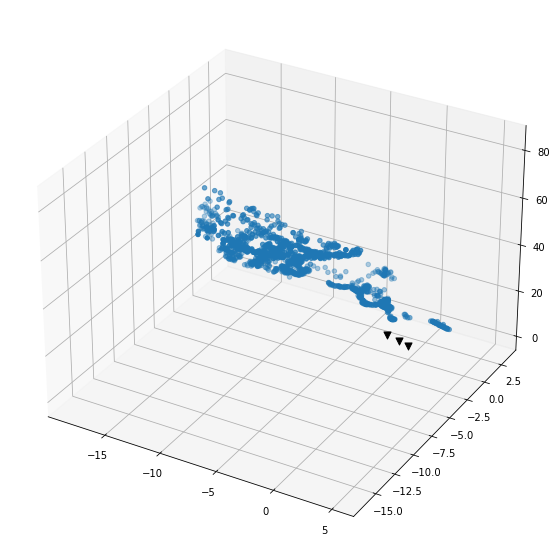

In [205]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(Qinliers[:,0],Qinliers[:,1],Qinliers[:,2])

colors = ['r', 'g', 'b']
for i in range(len(Pos)):
    ax.scatter(Pos[i][0], Pos[i][1], Pos[i][2], s = 50,marker = 'v',color = 'k')

plt.show()


# Exercise 11.5

In [38]:
#Load img
ims = []
for i in range(1,21):
    filepath = 'sequence/0000%02d.png'%i
    print(filepath)
    img = cv2.imread(filepath)
    im = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ims.append(im)

sequence/000001.png
sequence/000002.png
sequence/000003.png
sequence/000004.png
sequence/000005.png
sequence/000006.png
sequence/000007.png
sequence/000008.png
sequence/000009.png
sequence/000010.png
sequence/000011.png
sequence/000012.png
sequence/000013.png
sequence/000014.png
sequence/000015.png
sequence/000016.png
sequence/000017.png
sequence/000018.png
sequence/000019.png
sequence/000020.png


In [39]:
kps = [kp0,kp1,kp2]
des = [des0,des1,des2]

In [40]:
matches = [[],matches01,matches12]
matches

[[],
 array([[    0, 17933],
        [    9,   875],
        [   11,  3495],
        ...,
        [20702,    50],
        [20705,  1925],
        [20722,  3665]]),
 array([[    8,  3391],
        [    9,   766],
        [   22, 10737],
        ...,
        [21358,    26],
        [21359, 17275],
        [21371, 23163]])]

In [41]:
for i in range(3,20):    
    kp_i, des_i = sift.detectAndCompute(ims[i], None)
    kp_i = np.array([k.pt for k in kp_i]).astype('float32')
    kps.append(kp_i)
    des.append(des_i)

    matches_pre_cur = bf.match(des[i-1],des[i])
    matches_pre_cur = np.array([(m.queryIdx, m.trainIdx) for m in matches_pre_cur])
    matches.append(matches_pre_cur)
#matches the points between current figure and pre/prepre figure
    _, idx_prepre_pre, idx_pre_cur = np.intersect1d(matches[i-1][:,1], matches[i][:,0], return_indices=True)    
    points_prepre = kps[i-2][matches[i-1][idx_prepre_pre, 0]]
    points_pre = kps[i-1][matches[i-1][idx_prepre_pre, 1]]
    points_cur = kps[i][matches[i][idx_pre_cur, 1]]
#triangulate the points in 3D
    Q = cv2.triangulatePoints(Ps[i-2], Ps[i-1], points_prepre.T, points_pre.T)
    Qih = (Q[:-1]/Q[-1]).T.astype(np.float64)
# estimate the pose
    _, rvecs, tvecs, inliers = cv2.solvePnPRansac(Qih, points_cur, K, distCoeffs=np.zeros(5))
    Ri, _ = cv2.Rodrigues(rvecs)
    Orientationi = Ri.T
    Poistioni = - Ri.T @ tvecs
    Rs.append(Ri)
    ts.append(tvecs)
    Ps.append(K@np.hstack((Ri,tvecs)))
    Os.append(Orientationi)
    Pos.append(Poistioni)
#3Dpoints
    Qinliers = Qih[inliers.flatten()]
    Qs.append(Qinliers)
    print('Image %d inlier numbers is %d'%(i,len(inliers)))

Image 3 inlier numbers is 462
Image 4 inlier numbers is 1223
Image 5 inlier numbers is 1388
Image 6 inlier numbers is 2121
Image 7 inlier numbers is 2894
Image 8 inlier numbers is 2218
Image 9 inlier numbers is 1300
Image 10 inlier numbers is 1235
Image 11 inlier numbers is 830
Image 12 inlier numbers is 1018
Image 13 inlier numbers is 800
Image 14 inlier numbers is 61
Image 15 inlier numbers is 76
Image 16 inlier numbers is 299
Image 17 inlier numbers is 262
Image 18 inlier numbers is 175
Image 19 inlier numbers is 43


In [46]:
Qs[0]

array([[-18.48892593,  -0.8903091 ,  38.61859131],
       [-18.50211716,  -0.54758608,  38.6803093 ],
       [-18.51462936,  -0.97576511,  38.77082825],
       ...,
       [  4.93915939,  -2.58415318,  22.42534637],
       [  5.03199434,  -2.65038896,  22.47585487],
       [  5.11313915,  -2.57615113,  22.22411919]])

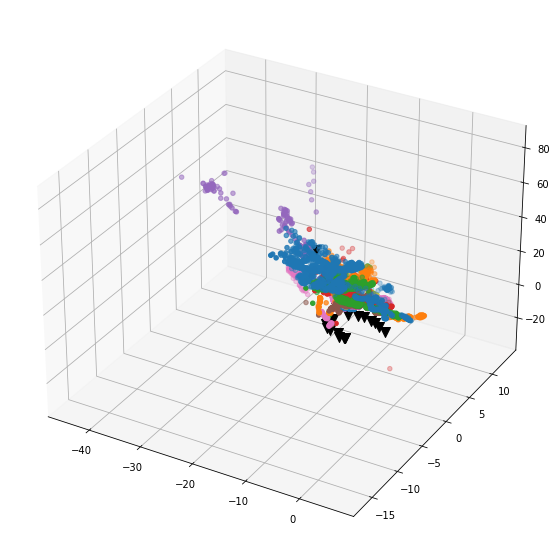

In [60]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
for i in range(2,20):
    ax.scatter(Qs[i-2][:,0],Qs[i-2][:,1],Qs[i-2][:,2])
    colors = ['r', 'g', 'b']
    ax.scatter(Pos[i][0], Pos[i][1], Pos[i][2], s = 100,marker = 'v',color = 'k')

plt.show()